Number of classes: 33
Training samples: 22545, Validation samples: 5637
Using device: cpu
Starting training...
Epoch [1/10]
Train Loss: 1.3993, Train Acc: 57.27%
Val Loss: 0.3701, Val Acc: 88.42%
--------------------------------------------------
Epoch [2/10]
Train Loss: 0.5083, Train Acc: 82.67%
Val Loss: 0.1719, Val Acc: 95.21%
--------------------------------------------------
Epoch [3/10]
Train Loss: 0.3735, Train Acc: 87.17%
Val Loss: 0.1299, Val Acc: 95.87%
--------------------------------------------------
Epoch [4/10]
Train Loss: 0.3002, Train Acc: 89.67%
Val Loss: 0.0933, Val Acc: 97.16%
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.2543, Train Acc: 90.91%
Val Loss: 0.0695, Val Acc: 97.94%
--------------------------------------------------
Epoch [6/10]
Train Loss: 0.2281, Train Acc: 92.11%
Val Loss: 0.0542, Val Acc: 98.49%
--------------------------------------------------
Epoch [7/10]
Train Loss: 0.2016, Train Acc: 92.93%
Val Loss: 0.0471, Val 

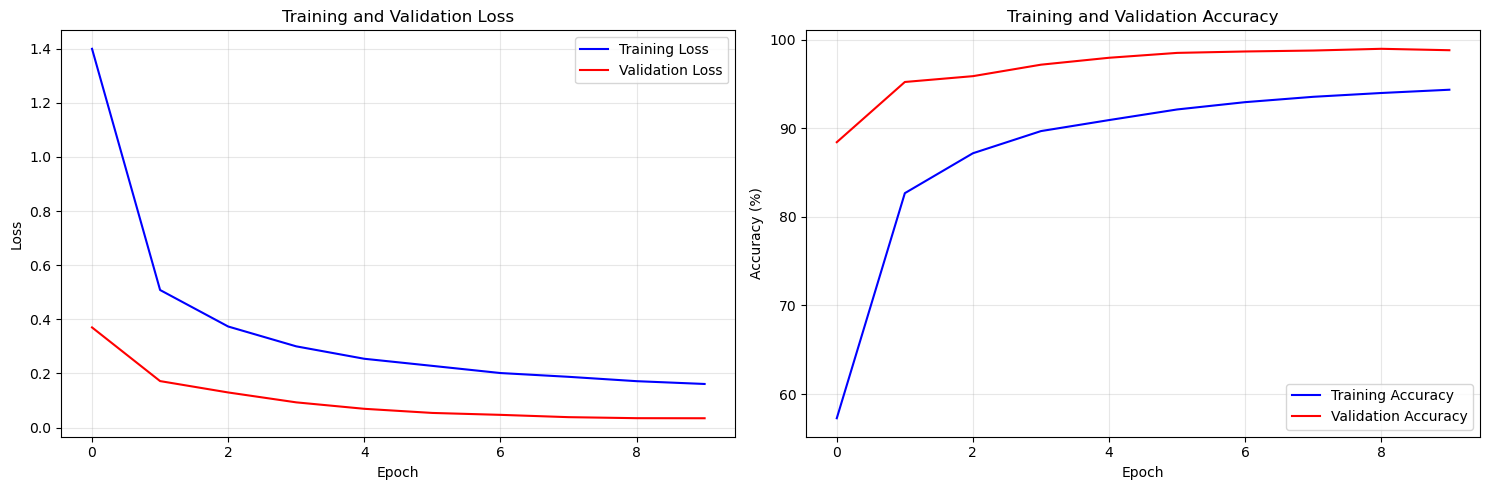

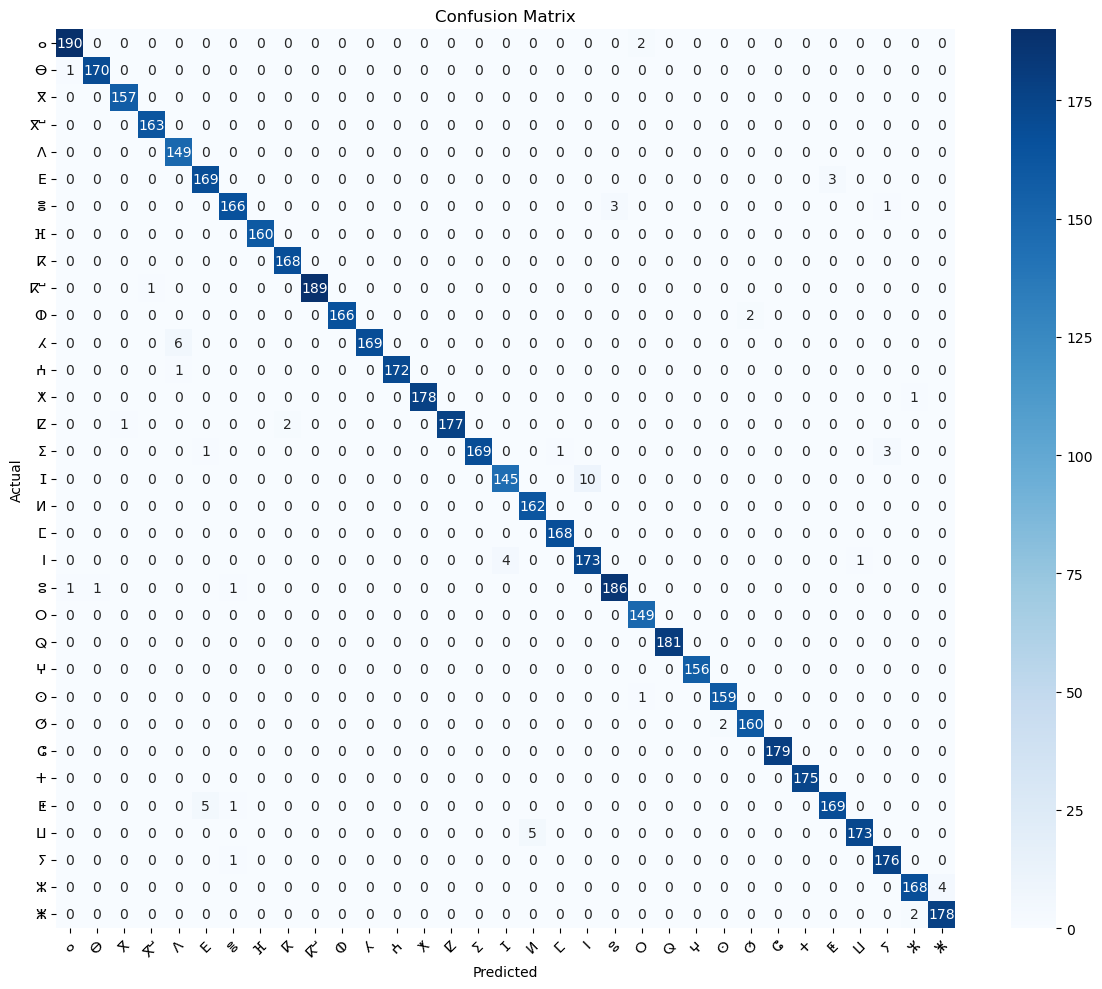

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           ⴰ       0.99      0.99      0.99       192
           ⴱ       0.99      0.99      0.99       171
           ⴳ       0.99      1.00      1.00       157
          ⴳⵯ       0.99      1.00      1.00       163
           ⴷ       0.96      1.00      0.98       149
           ⴹ       0.97      0.98      0.97       172
           ⴻ       0.98      0.98      0.98       170
           ⴼ       1.00      1.00      1.00       160
           ⴽ       0.99      1.00      0.99       168
          ⴽⵯ       1.00      0.99      1.00       190
           ⵀ       1.00      0.99      0.99       168
           ⵃ       1.00      0.97      0.98       175
           ⵄ       1.00      0.99      1.00       173
           ⵅ       1.00      0.99      1.00       179
           ⵇ       1.00      0.98      0.99       180
           ⵉ       1.00      0.97      0.99       174
           ⵊ       0.97      0.94      0.95       155
     

In [30]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import pandas as pd
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

class AMHCDDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file, header=None, names=['image_path', 'label'])
        self.root_dir = root_dir
        self.transform = transform
        # Map unique labels to indices
        self.label_map = {label: idx for idx, label in enumerate(sorted(self.labels_df['label'].unique()))}
        self.idx_to_label = {idx: label for label, idx in self.label_map.items()}
    
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.labels_df.iloc[idx]['image_path'])
        image = Image.open(img_path).convert('L')  # Grayscale
        label = self.labels_df.iloc[idx]['label']
        label_idx = self.label_map[label]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label_idx

class TifinaghCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # Grayscale input: 1 channel
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64 -> 32x32
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32 -> 16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16 -> 8x8
        )
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor (1, 64, 64)
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale to [-1, 1]
])

# Create dataset
dataset = AMHCDDataset(
    csv_file='amhcd-data-64/labels-map.csv',
    root_dir='amhcd-data-64',
    transform=transform
)

# Split dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Number of classes
num_classes = len(dataset.label_map)
print(f"Number of classes: {num_classes}")
print(f"Training samples: {train_size}, Validation samples: {val_size}")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = TifinaghCNN(num_classes=num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_predictions, all_labels

# Training loop with tracking
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("Starting training...")
for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_predictions, val_labels = validate_epoch(model, val_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)

# Plot training curves
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curve
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curve
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return cm

# Generate evaluation report
def generate_evaluation_report(y_true, y_pred, class_names):
    # Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    print("=" * 60)
    print("CLASSIFICATION REPORT")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Overall metrics
    accuracy = report['accuracy']
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']
    
    print("=" * 60)
    print("SUMMARY METRICS")
    print("=" * 60)
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Macro Average Precision: {macro_avg['precision']:.4f}")
    print(f"Macro Average Recall: {macro_avg['recall']:.4f}")
    print(f"Macro Average F1-Score: {macro_avg['f1-score']:.4f}")
    print(f"Weighted Average Precision: {weighted_avg['precision']:.4f}")
    print(f"Weighted Average Recall: {weighted_avg['recall']:.4f}")
    print(f"Weighted Average F1-Score: {weighted_avg['f1-score']:.4f}")
    
    return report

# Final evaluation on validation set
print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

# Get final predictions
model.eval()
final_predictions = []
final_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        final_predictions.extend(predicted.cpu().numpy())
        final_labels.extend(labels.cpu().numpy())

# Get class names
class_names = [dataset.idx_to_label[i] for i in range(num_classes)]

# Plot training curves
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

# Plot confusion matrix
cm = plot_confusion_matrix(final_labels, final_predictions, class_names)

# Generate evaluation report
report = generate_evaluation_report(final_labels, final_predictions, class_names)

# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'label_map': dataset.label_map,
    'num_classes': num_classes
}, 'tifinagh_cnn_model.pth')

print(f"\nModel saved as 'tifinagh_cnn_model.pth'")
print(f"Best validation accuracy: {max(val_accuracies):.2f}%")
print(f"Final validation accuracy: {val_accuracies[-1]:.2f}%")